## Preparation

### Activation Functions and Derivative

In [97]:
import numpy as np
from random import uniform
import sys


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def dtanh(x):
    return 1 - x * x


# The numerically stable softmax implementation
def softmax(x):
    # assuming x shape is [feature_size, batch_size]
    e_x = np.exp(x - np.max(x, axis=0))
    return e_x / e_x.sum(axis=0)

### Data I/O

In [98]:
# data I/O
data = open("data/steve-jobs-transcript.txt", "r").read()  # should be simple plain text file
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print("data has %d characters, %d unique." % (data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 11027 characters, 72 unique.


### Hyperparameters

Network size can be decided by hyperparameters.

In [99]:
emb_size = 4  # word/character embedding size
seq_length = 32  # number of steps to unroll the RNN for the truncated back-propagation algorithm
hidden_size = 32

# learning rate for the Adagrad algorithm. (this one is not 'optimized', only required to make the model learn)
learning_rate = 0.02
std = 0.02  # The standard deviation for parameter initilization
batch_size = 4

### Model Parameters

Here we initialize the parameters based an random uniform distribution, with the std of 0.01

In [100]:
# word embedding: each character in the vocabulary is mapped to a vector with $emb_size$ neurons
# Weight matrix to transform one-hot vectors to embedding X
Wex = np.random.randn(emb_size, vocab_size) * std

# Weight matrix to transform input X to hidden H
Wxh = np.random.randn(hidden_size, emb_size) * std

# Weight matrix to transform previous hidden states H_{t-1} to hidden H_t
Whh = np.random.randn(hidden_size, hidden_size) * std  # hidden to hidden

# Output layer: transforming the hidden states H to output layer
Why = np.random.randn(vocab_size, hidden_size) * std  # hidden to output

# The biases are typically initialized as zeros. But sometimes people init them with uniform distribution too.
bh = np.random.randn(hidden_size, 1) * std  # hidden bias
by = np.random.randn(vocab_size, 1) * std  # output bias

# These variables are momentums for the Adagrad algorithm
# Each parameter in the network needs one momentum correspondingly
mWex, mWxh, mWhh, mWhy = np.zeros_like(Wex), np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)

### Load Data into Memory

In [101]:
data_stream = np.asarray([char_to_ix[char] for char in data])

bound = (data_stream.shape[0] // (seq_length * batch_size)) * (seq_length * batch_size)
cut_stream = data_stream[:bound]
cut_stream = np.reshape(cut_stream, (batch_size, -1))

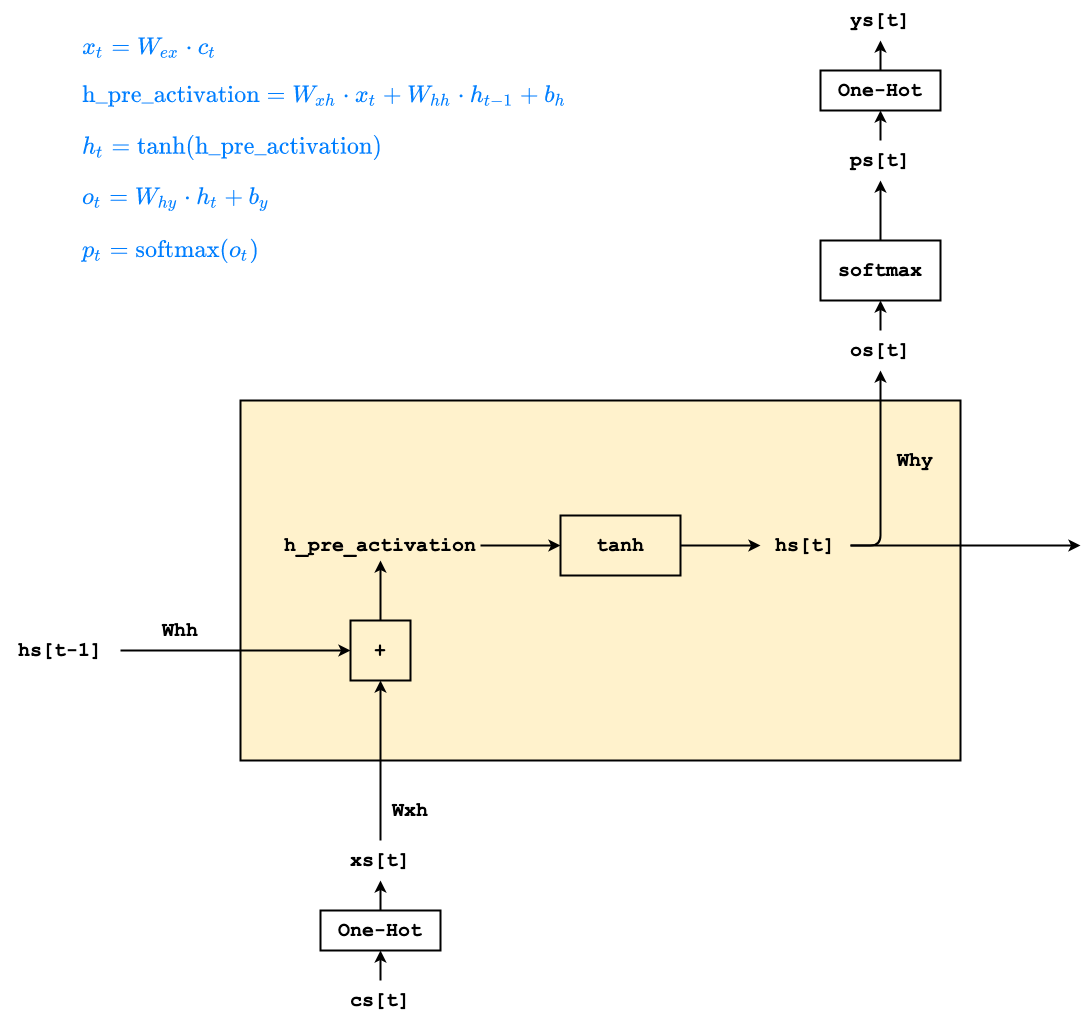

In [102]:
from IPython.display import Image
Image(filename='char-rnn.png')

## RNN Forward

In [103]:
def forward(inputs, labels, memory, batch_size=1):
    
    """
    RNN Forward propagation 
    """
    
    prev_h = memory
    
    # Here we use dictionaries to store the activations over time
    # Note from back-propagation implementation:
    # back-propagation uses dynamic programming to estimate gradients efficiently,
    # so we need to store the activations over the course of the forward pass.
    # And in the backward pass we will use the activations to compute the gradients.
    # (otherwise we will need to recompute them)
    
    cs = {} # characters at timesteps
    xs = {} # inputs to the RNNs at timesteps (embeddings)
    hs = {} # hidden states at timesteps
    os = {} # output layers at timesteps
    ps = {} # probability distributions at timesteps
    ys = {} # label at timesteps

    # The first memory (before training) is the previous (or initial) hidden state
    hs[-1] = np.copy(prev_h)

    # The loss will be accumulated over time
    loss = 0

    for t in range(inputs.shape[1]):

        # One-Hot vector representation for character input at time t
        cs[t] = np.zeros((vocab_size, batch_size))
        for b in range(batch_size):
            cs[t][inputs[b][t]][b] = 1

        # Transform the one hot vector to embedding
        # x = Wemb x c
        xs[t] = np.dot(Wex, cs[t])

        # Compute the hidden state of the network
        # H = tanh ( Wh . H + Wx . x )
        h_pre_activation = np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + bh
        hs[t] = np.tanh(h_pre_activation)

        # Output layer:
        # this is the unnormalized log probabilities for next chars (across all chars in the vocabulary)
        os[t] = np.dot(Why, hs[t]) + by

        # Softmax layer to get normalized probabilities:
        ps[t] = softmax(os[t])

        # The label is also an one-hot vector
        ys[t] = np.zeros((vocab_size, batch_size))
        for b in range(batch_size):
            ys[t][labels[b][t]][b] = 1

        # Cross entropy loss at time t:
        loss_t = np.sum(-np.log(ps[t]) * ys[t])

        # Accumulate the loss
        loss += loss_t

    # packaging the activations to use in the backward pass
    activations = (xs, cs, hs, os, ps, ys)
    last_hidden = hs[inputs.shape[1] - 1]
    return loss, activations, last_hidden

## RNN Backward

What we have to pay attention are the dimension and transpose.

Suppose $D = W \cdot X$ and $dD = \frac{\partial L}{\partial D}$. Then we have:

- $dW = \frac{\partial L}{\partial W} = dD \cdot X^T$

- $dX = \frac{\partial L}{\partial X} = W^T \cdot dD$

```python
# forward pass
W = np.random.randn(5, 10)
X = np.random.randn(10, 3)
D = W.dot(X)

# now suppose we had the gradient on D from above in the circuit
dD = np.random.randn(*D.shape) # same shape as D
dW = dD.dot(X.T) #.T gives the transpose of the matrix
dX = W.T.dot(dD)
```

In [104]:
def backward(activations, clipping=True, scale=True):
    """
    During the backward pass we follow the track of the forward pass
    the activations are needed so that we can avoid unnecessary re-computation
    """

    # Gradient initialization
    # Each parameter has a corresponding gradient (of the loss with respect to that gradient)
    dWex = np.zeros_like(Wex)
    dWxh = np.zeros_like(Wxh)
    dWhh = np.zeros_like(Whh)
    dWhy = np.zeros_like(Why)

    dbh, dby = np.zeros_like(bh), np.zeros_like(by)

    xs, cs, hs, os, ps, ys = activations

    # Here we need the gradient w.r.t to the hidden layer at the final time step
    # since this hidden layer is not connected to any future (final time step)
    # then we can initialize it as zero vectors
    dh = np.zeros_like(hs[0])
    bsz = dh.shape[-1]

    # the backward pass starts from the final step of the chain in the forward pass
    for t in reversed(range(inputs.shape[1])):

 
        # Cross entropy gradient: dL / do = p - y
        do = ps[t] - ys[t]

        if scale:
            do = do / bsz
            
        # The weights Wex, Wxh, Whh, Why, bh, by are shared to all input time steps 
        # so their gradients should be summed up

        # The gradients w.r.t to the weights and the bias that were used to create o[t]
        dWhy += np.dot(do, hs[t].T)
        dby += np.sum(do, axis=-1, keepdims=True)

        # Because h is connected to both o and the next h, we sum the gradients up
        dh = np.dot(Why.T, do) + dh

        # Backprop through the activation function (tanh)
        dtanh_h = 1 - hs[t] * hs[t]
        dh_pre_activation = dtanh_h * dh  # because h = tanh(h_pre_activation)

        # Next, since  H = tanh ( Wh . H + Wx . x + bh )
        # we use dh_pre_activation to backprop to dWh and dWx

        # Gradient of the bias and weight, this is similar to dby and dWhy for the H term
        dbh += np.sum(dh_pre_activation, axis=-1, keepdims=True)
        dWhh += np.dot(dh_pre_activation, hs[t - 1].T)
        
        # we need this term for the recurrent connection (previous bptt step needs this)
        dh = np.dot(Whh.T, dh_pre_activation)

        # similarly for the x term
        dWxh += np.dot(dh_pre_activation, xs[t].T)

        # backward through the embedding
        dx = np.dot(Wxh.T, dh_pre_activation)

        # finally backward to the embedding projection
        dWex += np.dot(dx, cs[t].T)

    if clipping:
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -1, 1, out=dparam)  # clip to mitigate exploding gradients

    gradients = (dWex, dWxh, dWhh, dWhy, dbh, dby)
    return gradients

## Sample

In [105]:
def sample(h, seed_ix, n):
    """
    Sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    c = np.zeros((vocab_size, 1))
    c[seed_ix] = 1
    generated_chars = []
    for t in range(n):
        x = np.dot(Wex, c)
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        o = np.dot(Why, h) + by
        p = softmax(o)

        # the the distribution, we randomly generate samples:
        ix = np.random.multinomial(1, p.ravel())
        c = np.zeros((vocab_size, 1))

        for j in range(len(ix)):
            if ix[j] == 1:
                index = j
        c[index] = 1
        generated_chars.append(index)

    return generated_chars

## Train

In [106]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [ ]:
n, p = 0, 0
data_length = cut_stream.shape[1]

SAMPLE_LEN = 1500
MAX_ITER = 2000000

smooth_loss = -np.log(1.0 / vocab_size) * seq_length  # loss at iteration 0
loss_arr = np.array([])

while n < MAX_ITER:
    
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p + seq_length + 1 >= data_length or n == 0:
        hprev = np.zeros((hidden_size, batch_size))  # reset RNN memory
        p = 0  # go back to start of data

    inputs = cut_stream[:, p : p + seq_length]
    targets = cut_stream[:, p + 1 : p + 1 + seq_length]

    # sample from the model now and then
    if n % 1000 == 0:
        h_zero = np.zeros((hidden_size, 1))
        sample_ix = sample(h_zero, inputs[0][0], SAMPLE_LEN)
        txt = "".join(ix_to_char[ix] for ix in sample_ix)
        print("----\n %s \n----" % (txt,))

    # forward seq_length characters through the net and fetch gradient
    loss, activations, hprev = forward(inputs, targets, hprev, batch_size=batch_size)
    gradients = backward(activations)
    dWex, dWxh, dWhh, dWhy, dbh, dby = gradients
    smooth_loss = smooth_loss * 0.999 + loss / batch_size * 0.001
    loss_arr = np.append(loss_arr, smooth_loss)
    if n % 1000 == 0:
        print("iter %d, loss: %f" % (n, smooth_loss))  # print progress

    # perform parameter update with Adagrad
    for param, dparam, mem in zip(
        [Wex, Wxh, Whh, Why, bh, by], [dWex, dWxh, dWhh, dWhy, dbh, dby], [mWex, mWxh, mWhh, mWhy, mbh, mby]
    ):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

    p += seq_length  # move data pointer
    n += 1  # iteration counter
    
    
# Plot trend of loss when training is finished
x = np.arange(MAX_ITER)
plt.plot(x, loss_arr)